In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from datetime import datetime as dt
from db.db_operations import execute_db_operations
import pandas as pd
from utils import prompt_utils
import numpy as np
import utils.utils as utils

from generators.full_generators import (
    create_company_data
)

company_name = "Lego"

In [2]:
import pandas as pd
from generators.llm_generators import tailor_coa_names_llm

df_accounts = pd.read_csv("data/inputdata/coa_general.csv", sep = ";")
df_coa = tailor_coa_names_llm(df_accounts, company_name="Lego")

In [3]:
def generate_line_items_llm(company_name: str, 
                            count: int = 100, 
                            category_name: str = "COGS", 
                            financial_total: float = 100000.0, 
                            df_business_units: pd.DataFrame = pd.DataFrame(),
                            df_parties: pd.DataFrame = pd.DataFrame(),
                            df_accounts: pd.DataFrame = pd.DataFrame(),
                            model: str = "gpt-4.1", 
                            temp: float = 0.5):
    
    """
    Generate COGS (Cost of Goods Sold) items for a company.
    Each item should map to Product Expense or Service Expense accounts in the COA.
    """

    accounts_subset_csv = df_accounts.iloc[:, :2].to_csv(index=False, header=False, sep=";")
    business_units_csv = df_business_units.iloc[:, :2].to_csv(index=False, header=False, sep=";")
    parties_csv = df_parties.iloc[:, :3].to_csv(index=False, header=False, sep=";")

    client = prompt_utils.get_openai_client()
    over_request_count = int(np.floor(int(count) * 1.4))

    header = "document_number;posting_date;company;bu_id;bu_name;party_id;party_name;account_id;account_name;item_name;proportionality;unit_price;markdown;category"
    constraints = prompt_utils.get_standard_constraints(header, over_request_count)
    ctxb = prompt_utils._ctx_block(company_name)

    PROMPT_LINES = f"""
    You are generating aggregated GL driver lines for synthetic financial data.
    This is NOT journal entries yet. This is the template that will later be exploded
    into many detailed postings with dates, document numbers, etc.

    Company: {company_name}
    Category to generate: {category_name}   # e.g. Revenue, COGS, FixedCost, EBIT
    Number of rows to generate (before later down-splitting): {over_request_count}

    ACCOUNTS (only use these AccountKeys for this category):
    {accounts_subset_csv}

    BUSINESS UNITS (use these bu_id values only):
    {business_units_csv}

    PARTIES (customers, vendors, internal units):
    {parties_csv}

    YOUR TASK
    Generate {over_request_count} high-level economic driver lines for the given category {category_name}.

    For each item, there must be 2-3 lines. Proportionality should be split accordingly.
    ONLY 5% of all lines must be intercompany. 
    
    COLUMNS AND ORDER
    You MUST output a semicolon-separated CSV with columns in this exact order:

    {header}
    
    Column definitions:
    - bu_id:
    - Must match one of the bu_id values from BUSINESS UNITS.
    - Pick whichever BU is most natural for that driver (e.g. retail cost -> retail BU).

    - party_id:
    - Revenue:
        - If AccountKey is an intercompany revenue account, party_id must be an INTERNAL_BU from PARTIES. IMPORTANT: MAX {over_request_count*0.05} or 5% internal sales total. 
        - Otherwise use a CUSTOMER from PARTIES.
    - COGS:
        - If AccountKey is an intercompany COGS account, party_id must be an INTERNAL_BU. IMPORTANT: MAX {over_request_count*0.05} or 5% internal sales total. 
        - Otherwise use a VENDOR from PARTIES.
    - FixedCost:
        - Can be blank unless there's a clear vendor/counterparty (e.g. "External legal services").
    - EBIT (other income/expense categories):
        - Can be blank unless it's obviously a financing/royalty counterparty.

    - AccountKey:
    - Must be copied from the provided ACCOUNTS list.
    - Only use AccountKeys valid for this category:
        - Revenue  → 4001–4009
        - COGS     → 4003, 4006, 4009
        - FixedCost→ 5001–5027
        - EBIT     → 6001–6503
        - BalanceSheet → 1001–3005

    - AccountName:
    - Must be copied from 'name' in the accounts list for that AccountKey.

    - item_name:
    - BE specific. Must look like a real item or service description. ex. "Consulting services", "Plastic gloves" etc.
    - MUST NOT include dates, months, regions, shipment references, batch IDs, PO numbers, 'January', 'Copenhagen', etc.
    - MUST NOT include "for" phrases or detailed invoice descriptions.

    `proportionality` rules:
    - `proportionality` = share of total budget
    -  Represents how large this driver is relative to the TOTAL for this category.
    -  Must be larger than 1
    
    - unit_price (sales):
    - unit_price of the item in DKK.

    - markdown: 
    - Conversion of unit_price sales to cost.
    - E.g. 0.25 = 25% markdown on cost.

    - category:
    - Must equal {category_name} exactly, for every row.

    FINAL OUTPUT RULES
    - Output ONLY CSV rows, one row per driver line.
    - Use semicolons as separators.
    - Do NOT include headers.
    - Do NOT include document_number.
    - Do NOT include amount_DKK.
    - Do NOT include unit_price.
    - Do NOT include explanations, notes, or markdown fences.

    {constraints}
    """
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful financial analyst and ERP mapping assistant."},
            {"role": "user", "content": PROMPT_LINES},
        ],
        temperature=temp,
    )

    df_lines = prompt_utils.parse_and_truncate_csv(response.choices[0].message.content, count)
    df_lines = utils.convert_column_to_percentage(df_lines, "proportionality", scale=1.0)
    df_lines["annual_spend"] = np.round(df_lines["proportionality"] * financial_total, -2)
    df_lines = df_lines.drop(columns=["account_name", "document_number", "posting_date", "proportionality", "company"])
    return df_lines

In [4]:
def generate_bus_llm(company_name: str, count: int = 100, model: str = "gpt-4.1", temp: float = 0.8):
    client = prompt_utils.get_openai_client()
    over_request_count = int(np.floor(int(count) * 1.4))
    header = "bu_id;bu_name;bu_type;country;company_code"
    constraints = prompt_utils.get_standard_constraints(header, over_request_count)
    ctxb = prompt_utils._ctx_block(company_name)

    PROMPT_BUSINESS_UNITS = f"""
    You are creating a realistic internal org structure for a company.

    Company: {company_name}

    Task:
    Generate 10-15 business units and departments that reflect how this company would actually operate (production sites, regional sales orgs, HQ functions, logistics hubs, shared services, etc.).

    Return ONLY a semicolon-separated CSV with the following columns in this exact order:
    {header}

    Definitions:
    - BU_ID: stable ID like BU001, BU002, ...
    - BU_Name: human label, e.g. "{company_name} Retail", "{company_name} Factory". ALSO WE need a headquarter in the correct country. JUST CALLED "{company_name} HQ".
    - BU_Type: one of [Factory, Retail, HQ, Licensing, Shared Service, Online, Distribution]
    - Country: realistic country/region for that BU. Max of 5 countries total. 
    - CompanyCode: For each country make a company Code. Start at 1000 and increment by 250 for each new country. 

    Rules:
    - Make sure there is at least one HQ / corporate finance unit.
    - Make sure there are both commercial (sales/retail) and production/supply-side units.
    - IDs must be unique.
    {constraints}
    """

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "system", "content": "You are a helpful data assistant and B2B vendor segmentation expert."},
                  {"role": "user", "content": PROMPT_BUSINESS_UNITS}],
        temperature=temp,
    )
    
    return prompt_utils.parse_and_truncate_csv(response.choices[0].message.content, count)
    


In [5]:
def generate_parties(company_name: str, 
                            count: int = 100, 
                            df_business_units: pd.DataFrame = pd.DataFrame(),
                            model: str = "gpt-5", 
                            temp: float = 1):
    
    """
    Generate COGS (Cost of Goods Sold) items for a company.
    Each item should map to Product Expense or Service Expense accounts in the COA.
    """
    business_units_csv = df_business_units.iloc[:, :4].to_csv(index=False, header=False, sep=";")
    
    client = prompt_utils.get_openai_client()
    over_request_count = int(np.floor(int(count) * 1.4))
    
    header = "party_ID;party_name;party_type;party_country"
    constraints = prompt_utils.get_standard_constraints(header, over_request_count)
    ctxb = prompt_utils._ctx_block(company_name)

    PROMPT_PARTIES = f"""
    You are creating master data for all counterparties in this company.

    Company: {company_name}

    Internal business units (BU master data):
    {business_units_csv}

    Task:
    1. For each internal BU, create a row where that BU is treated as a party.
    2. Also create external customers (distributors, retailers, channels).
    3. Also create external vendors (materials suppliers, logistics, energy, maintenance, IT services).

    Generate {over_request_count} rows TOTAL across all types. About 47.5% for custumers, 47.5% for vendors, and 5% for internal sales.

    Return ONLY a semicolon-separated CSV with columns in this exact order:
    {header}

    Where:
    - party_ID:
    - INTERNAL_BU => bu_id for the party. Can be found in the provided CSV. - MAX {over_request_count*0.05} or 5% internal sales total. 
    - CUSTOMER    => "CUS###"
    - VENDOR      => "VEN###"
    - party_Type is exactly one of [INTERNAL_BU, CUSTOMER, VENDOR]
    - INTERNAL_BU rows must include ALL internal business units given above.
    - IF INTERNAL_BU: It cannot be identical to bu_id on the same line. They must sell between units. 
    - party_name for INTERNAL_BU must match BU_Name exactly.
    - party_country: country of origin of the party. 
    - No commentary, no markdown, only CSV.

    {constraints}

    """
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful financial analyst and ERP mapping assistant."},
            {"role": "user", "content": PROMPT_PARTIES},
        ],
        temperature=temp,
    )

    df_parties = prompt_utils.parse_and_truncate_csv(response.choices[0].message.content, count)

    return df_parties

In [ ]:
def generate_roles_and_departments_llm(company_name: str, 
                       count: int = 100, 
                       model: str = "gpt-4.1", 
                       df_business_units: pd.DataFrame = pd.DataFrame(),
                       temp: float = 0.9):
    client = prompt_utils.get_openai_client()

    over_request_count = int(np.floor(int(count) * 1.4))

    header = "role_name;department;department_id;bu_id"
    constraints = prompt_utils.get_standard_constraints(header, over_request_count)
    ctxb = prompt_utils._ctx_block(company_name)

    business_units_csv = df_business_units.iloc[:, :2].to_csv(index=False, header=False, sep=";")
    
    prompt = f"""
    You are an HR and industry expert. Generate {over_request_count} employee roles and departments for a large company like {company_name}.

    Internal business units (BU master data):
    {business_units_csv}
    
    
    Output format:
    - CSV with columns: {header}
    - Duplicates are ALLOWED and ENCOURAGED for common roles.
    - Rank by highest paid roles first. Any duplicates should be together. 
    
    COLS: 
    - role_name: realistic job title. Must include CEO and CFO.
    - department: name of the department the role belongs to. Ex. Data Scientist -> R&D. Must be an actual realistic department name.
    - department_id: stable ID for the department, e.g. "DPT001", "DPT002".
    - bu_id: assign each role to one of the bu_id's from the internal business units list. Ex. CFO -> HQ BU.

    Distribution requirements:
    - 60–80% must be generic base titles without seniority modifiers, e.g.:
    Software Engineer, Data Analyst, Consultant, Accountant, Sales Representative,
    Customer Support Specialist, Marketing Specialist, HR Generalist, Operations Coordinator,
    Procurement Specialist, Warehouse Associate, Project Manager, Business Analyst,
    QA Engineer, IT Support Specialist.
    - ≤10% may include seniority prefixes (Senior, Lead, Director, Head, Chief). Prefer none.
    - ≤3 entries total may be C‑level (CEO/CFO/CTO/etc.) or VP.
    - Avoid hyper‑granular one-offs; repetition of core roles is preferred.

    Style constraints:
    - Avoid prefixes: Senior, Lead, Director, Head, Chief, Principal, Staff — unless within the ≤10% cap.
    - Avoid internship/student titles.
    - Keep roles realistic for Denmark-only operations; no global country managers.

    For context, here is a short version of the lastest year-end report for {company_name}:
    {ctxb}

    {constraints}
    """.strip()

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "system", "content": "You are a helpful data analyst and HR expert."},
                  {"role": "user", "content": prompt}],
        temperature=temp,
    )
    df_roles = prompt_utils.parse_and_truncate_csv(response.choices[0].message.content, count)
    df_departments = df_roles.iloc[:,-3:].drop_duplicates("department").reset_index(drop=True)
    df_roles = df_roles.drop(columns=["department", "bu_id"])
    return df_roles, df_departments

In [ ]:

# General function where you  can add a dimension and a count: 
def generate_items_llm(company_name: str, finiancial_total: Dict, count_bu: int = 15, count_rev: int = 150, count_emp: int=300, count_parties: int = 100, count_cogs: int=100, ) -> Dict:
    df_bus = generate_bus_llm(company_name=company_name, model="gpt-4.1", temp=0.7, count=count_bu)
    df_roles, df_departments = generate_roles_and_departments_llm(company_name=company_name, count=count_emp, df_business_units=df_bus)
    df_parties = generate_parties(company_name=company_name, model="gpt-4.1", temp=0.7, count=count_parties, df_business_units=df_bus)

    if count_rev > 300: count_run=3; if 300 > count_rev > 150: count_run =2

    count_rev_new = np.ceil(count_rev/count_run)
    for i in range(count_run): 
        df_revenue = generate_line_items_llm(company_name=company_name, 
                                             count=count_rev_new, 
                                             category_name="Revenue", 
                                             financial_total=(finiancial_total["Revenue"]/count_run), 
                                             df_business_units=df_bus,
                                             df_parties=df_parties,
                                             df_accounts=df_coa)
        df_revenue.concat()

    # Similar for cogs:
    # for i in range(count cogs): 
    #  

    if args and str:
        df_extra_dim = generate_line_items_llm(company_name=company_name, 
                                               count=args, 
                                               category_name=str, 
                                               financial_total=(finiancial_total[str]/count_run), 
                                               df_business_units=df_bus,
                                               df_parties=df_parties,
                                               df_accounts=df_coa)


In [306]:
df_rev_ic  = df_revenue.query("account_id == 4007").copy()
df_cogs_ic = df_cogs.query("account_id == 4009").copy()

In [23]:
def mirror_intercompany_flows(df_revenue: pd.DataFrame,
                              df_cogs: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create mirrored intercompany entries so that total intercompany balances net to zero.

    Parameters
    ----------
    df_rev_ic : pd.DataFrame
        Intercompany revenue lines (e.g., account_id = 4007).
    df_cogs_ic : pd.DataFrame
        Intercompany COGS lines (e.g., account_id = 4009).

    Returns
    -------
    rev_mirror : pd.DataFrame
        New revenue lines created from intercompany COGS (4009 -> 4007).
    cogs_mirror : pd.DataFrame
        New COGS lines created from intercompany revenue (4007 -> 4009).
    """
    df_rev_ic  = df_revenue.query("account_id == 4007").copy()
    df_cogs_ic = df_cogs.query("account_id == 4009").copy()

    # --- Helper: swap BU <-> Party columns ---
    def swap_bu_and_party(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df["bu_id"], df["party_id"] = df["party_id"], df["bu_id"]
        df["bu_name"], df["party_name"] = df["party_name"], df["bu_name"]
        return df

    # --- Revenue → mirror into COGS ---
    cogs_mirror = df_rev_ic.copy()
    cogs_mirror = swap_bu_and_party(cogs_mirror)
    cogs_mirror["account_id"] = 4009
    cogs_mirror["category"] = "COGS"
    
    # --- COGS → mirror into Revenue ---
    rev_mirror = df_cogs_ic.copy()
    rev_mirror = swap_bu_and_party(rev_mirror)
    rev_mirror["account_id"] = 4007
    rev_mirror["category"] = "Revenue"

    df_revenue_final = pd.concat([df_revenue, rev_mirror], ignore_index=True)
    df_cogs_final    = pd.concat([df_cogs, cogs_mirror], ignore_index=True)
    
    return df_revenue_final, df_cogs_final

In [24]:
df_revenue, df_cogs = mirror_intercompany_flows(df_revenue, df_cogs)

In [25]:
df_cogs

,bu_id,bu_name,party_id,party_name,account_id,item_name,unit_price,markdown,category,annual_spend
0,BU010,Lego Richmond Factory,VEN014,Sinopec,4003,Polypropylene resin granules,27.5,0.21,COGS,8019600.0
1,BU010,Lego Richmond Factory,VEN015,Neste,4003,Bio-based plastic pellets,34.2,0.24,COGS,6748200.0
2,BU011,Lego Jiaxing Factory,VEN014,Sinopec,4003,Polyethylene molding compound,28.7,0.20,COGS,6943800.0
3,BU011,Lego Jiaxing Factory,VEN015,Neste,4003,Recycled plastic compound,31.9,0.22,COGS,5672400.0
4,BU010,Lego Richmond Factory,VEN017,Maersk,4003,Ocean freight for container shipments,17.1,0.12,COGS,3325200.0
...,...,...,...,...,...,...,...,...,...,...
130,BU011,Lego Richmond Factory,BU010,Lego Jiaxing Factory,4009,Intercompany parts transfer,30.0,0.17,COGS,3423000.0
131,BU004,Lego Shanghai Distribution,BU012,Lego Distribution Center Billund,4009,Bulk product shipment,12.0,0.10,COGS,489000.0
132,BU017,Lego Customer Service Center Americas,BU019,Lego Licensing & Partnerships EMEA,4009,Replacement parts fulfillment,9.0,0.07,COGS,195600.0
133,BU019,Lego Licensing & Partnerships EMEA,BU017,Lego Customer Service Center Americas,4009,Licensed product shipment,8.0,0.06,COGS,195600.0


In [250]:
""" 
Make code for this:

cogs_amount_new = sum(df_revenue["annual_cost"])
cogs_amount_orig = sum(df_revenue["annual_cost"])*0.98

perchentage_cogs_diff = ((cogs_amount_orig - cogs_amount_new) / cogs_amount_new)
correction_factor = 1 + perchentage_cogs_diff
df_revenue["annual_cost"] = df_revenue["annual_cost"]*0.98

cogs_amount = sum(df_revenue["annual_cost"])
"""

' \nMake code for this:\n\ncogs_amount_new = sum(df_revenue["annual_cost"])\ncogs_amount_orig = sum(df_revenue["annual_cost"])*0.98\n\nperchentage_cogs_diff = ((cogs_amount_orig - cogs_amount_new) / cogs_amount_new)\ncorrection_factor = 1 + perchentage_cogs_diff\ndf_revenue["annual_cost"] = df_revenue["annual_cost"]*0.98\n\ncogs_amount = sum(df_revenue["annual_cost"])\n'

In [27]:
def get_party_list(
    df_fact: pd.DataFrame,
    df_parties: pd.DataFrame,
    df_bus: pd.DataFrame,
    name: str = "party"
) -> pd.DataFrame:  
    
    df_list = df_fact[["party_id", "party_name"]].drop_duplicates("party_id")
    df_list = df_list.merge(df_parties, left_on="party_id", right_on="party_ID", how="left")
    df_list = df_list.drop(columns=["party_name_y", "party_ID"])
    df_list = df_list.rename(columns={"party_name_x": "party_name"})

    mask_nan = df_list['party_country'].isna()

    # Merge on matching names (party_name ↔ bu_name)
    df_list.loc[mask_nan, 'party_country'] = (
        df_list.loc[mask_nan, 'party_name']
        .map(df_bus.set_index('bu_name')['country'])
    )

    df_list.loc[mask_nan, 'party_type'] = 'INTERNAL_BU'

    # === 3. Dynamic renaming ===
    rename_dict = {
        "party_id": f"{name}_id",
        "party_name": f"{name}_name",
        "party_type": f"{name}_type",
        "party_country": f"{name}_country",
    }

    df_list = df_list.rename(columns=rename_dict)
    df_terms = pd.read_csv("data/inputdata/generic_terms.csv", sep=",")
    df_list["terms_id"] = pd.Series(np.random.choice(df_terms["terms_id"], size=len(df_list), replace=True)).reset_index(drop=True)

    return df_list

df_customers = get_party_list(df_revenue, df_parties, df_bus, "customer")
df_vendors = get_party_list(df_cogs, df_parties, df_bus, "vendor")

In [28]:
df_terms = pd.read_csv("data/inputdata/generic_terms.csv", sep=",")

In [29]:
# Function to generate item IDs
def generate_item_id(prefix="ITEM", start_num=1000):
    """Generate sequential item IDs with a prefix"""
    counter = start_num
    while True:
        yield f"{prefix}{counter:04d}"
        counter += 1

# Create item IDs for products and COGS
df_products = df_revenue[["item_name", "unit_price"]].drop_duplicates("item_name")
df_spend = df_cogs[["item_name", "unit_price"]].drop_duplicates("item_name")

# Generate item IDs for products
item_id_gen = generate_item_id("", 1000)
df_products["item_id"] = [next(item_id_gen) for _ in range(len(df_products))]

# Generate item IDs for COGS items  
item_id_gen_cogs = generate_item_id("", 2000)
df_spend["item_id"] = [next(item_id_gen_cogs) for _ in range(len(df_spend))]

print(f"Generated {len(df_products)} product item IDs")
print(f"Generated {len(df_spend)} COGS item IDs")

Generated 178 product item IDs
Generated 115 COGS item IDs


In [30]:
# 1) Map product names in df_revenue to product_id
rev_map = df_products[["item_id","item_name"]]
df_revenue = df_revenue.merge(rev_map, left_on="item_name", right_on="item_name", how="left")
df_revenue["item_id"] = df_revenue["item_id"].astype("Int64")
df_revenue.drop(columns=["item_name","item_name"], inplace=True)

# 2) Map spend names in df_cogs to spend_id
spend_map = df_spend[["item_id","item_name"]]
df_cogs = df_cogs.merge(spend_map, left_on="item_name", right_on="item_name", how="left")
df_cogs["item_id"] = df_cogs["item_id"].astype("Int64")
df_cogs.drop(columns=["item_name","item_name"], inplace=True)

# Validation
#assert df_revenue["item_id"].notna().mean() > 0.95, "Too many unmapped products in revenue"
#assert df_cogs["item_id"].notna().mean() > 0.95, "Too many unmapped spend items in COGS"


In [31]:
df_inventory

,bu_id,bu_name,party_id,party_name,account_id,item_name,unit_price,markdown,category,annual_spend
0,BU010,Lego Richmond Factory,VEN014,Sinopec,1003,ABS plastic granules,6.7,0.0,Inventory,1075400.0
1,BU010,Lego Richmond Factory,VEN011,Celanese,1003,Polycarbonate resin,8.1,0.0,Inventory,1075400.0
2,BU010,Lego Richmond Factory,VEN015,Neste,1003,Recycled plastic pellets,7.9,0.0,Inventory,1062300.0
3,BU011,Lego Jiaxing Factory,VEN014,Sinopec,1003,Polypropylene granules,7.2,0.0,Inventory,1036100.0
4,BU011,Lego Jiaxing Factory,VEN015,Neste,1003,Bio-based plastic granules,9.5,0.0,Inventory,1023000.0
...,...,...,...,...,...,...,...,...,...,...
145,BU004,Lego Distribution Center Billund,BU019,Lego Customer Service Center Americas,1006,Intercompany sample sets,0.0,0.0,Inventory,131100.0
146,BU004,Lego Distribution Center Billund,BU021,Lego Retail China,1006,Intercompany display sets,0.0,0.0,Inventory,131100.0
147,BU007,Lego Distribution Center Mexico,BU003,Lego Shared Services Center,1006,Intercompany returns,0.0,0.0,Inventory,131100.0
148,BU007,Lego Distribution Center Mexico,BU008,Lego Retail North America,1006,Intercompany defective stock,0.0,0.0,Inventory,131100.0


In [32]:
df_revenue

,bu_id,bu_name,party_id,party_name,account_id,unit_price,markdown,category,annual_spend,item_id
0,BU005,Lego Retail Europe,CUS002,Walmart,4001,749.0,0.18,Revenue,3461500.0,1000
1,BU008,Lego Retail North America,CUS004,Amazon US,4001,1299.0,0.22,Revenue,5192300.0,1001
2,BU008,Lego Retail North America,CUS004,Amazon US,4002,1299.0,-0.16,Revenue,576900.0,1002
3,BU008,Lego Retail North America,CUS004,Amazon US,4001,2599.0,0.23,Revenue,3076900.0,1003
4,BU013,Lego Retail Asia Pacific,CUS032,Ito Yokado,4001,849.0,0.21,Revenue,3653800.0,1004
...,...,...,...,...,...,...,...,...,...,...
220,BU021,Lego Richmond Factory,BU010,Lego Retail China,4007,249.0,0.10,Revenue,736700.0,1160
221,BU017,Lego Richmond Factory,BU010,Lego Licensing & Partnerships EMEA,4007,699.0,0.14,Revenue,654800.0,1161
222,BU019,Lego Jiaxing Factory,BU011,Lego Customer Service Center Americas,4007,899.0,0.12,Revenue,573000.0,1162
223,BU020,Lego Jiaxing Factory,BU011,Lego Licensing & Partnerships Americas,4007,599.0,0.13,Revenue,491100.0,1163


In [33]:
df_revenue.drop(columns=["bu_name","party_name"], inplace=True)
#df_revenue["annual_cost"] = np.round(df_revenue["annual_spend"] * (1 - df_revenue["markdown"]), -2) 

In [34]:
df_cogs.drop(columns=["bu_name","party_name"], inplace=True) 
# df_cogs.drop(columns=["markdown"], inplace=True) df_cogs.drop(columns=["markdown"], inplace=True)
#df_cogs["annual_cost"] = np.nan

In [38]:
df_revenue

,bu_id,party_id,account_id,unit_price,markdown,category,annual_spend,item_id
0,BU005,CUS002,4001,749.0,0.18,Revenue,3461500.0,1000
1,BU008,CUS004,4001,1299.0,0.22,Revenue,5192300.0,1001
2,BU008,CUS004,4002,1299.0,-0.16,Revenue,576900.0,1002
3,BU008,CUS004,4001,2599.0,0.23,Revenue,3076900.0,1003
4,BU013,CUS032,4001,849.0,0.21,Revenue,3653800.0,1004
...,...,...,...,...,...,...,...,...
220,BU021,BU010,4007,249.0,0.10,Revenue,736700.0,1160
221,BU017,BU010,4007,699.0,0.14,Revenue,654800.0,1161
222,BU019,BU011,4007,899.0,0.12,Revenue,573000.0,1162
223,BU020,BU011,4007,599.0,0.13,Revenue,491100.0,1163


In [300]:
# Group by annual_spend per bu_id for Revenue and COGS
print("=== REVENUE - Annual Spend per Business Unit ===")
revenue_by_bu = df_revenue.groupby("bu_id")["annual_spend"].sum().reset_index()
revenue_by_bu = revenue_by_bu.sort_values("annual_spend", ascending=False)
print(revenue_by_bu.to_string(index=False))

print(f"\nTotal Revenue Annual Spend: {df_revenue['annual_spend'].sum():,.0f}")

print("\n" + "="*50)
print("=== COGS - Annual Spend per Business Unit ===")
cogs_by_bu = df_cogs.groupby("party_id")["annual_spend"].sum().reset_index()
cogs_by_bu = cogs_by_bu.sort_values("annual_spend", ascending=False)
print(cogs_by_bu.to_string(index=False))

print(f"\nTotal COGS Annual Spend: {df_cogs['annual_spend'].sum():,.0f}")

print("\n" + "="*50)
print("=== SUMMARY COMPARISON ===")
print(f"Revenue Total: {df_revenue['annual_spend'].sum():,.0f}")
print(f"COGS Total:    {df_cogs['annual_spend'].sum():,.0f}")
print(f"Difference:    {df_revenue['annual_spend'].sum() - df_cogs['annual_spend'].sum():,.0f}")
print(f"COGS as % of Revenue: {(df_cogs['annual_spend'].sum() / df_revenue['annual_spend'].sum() * 100):.1f}%")

=== REVENUE - Annual Spend per Business Unit ===
bu_id  annual_spend
BU007    36338500.0
BU015    32119500.0
BU005    30247200.0
BU013    28370000.0
BU003    25648000.0
BU020    25335000.0
BU019    16854000.0
BU014    14681900.0
BU017    10920900.0
BU009     9339300.0
BU021     6684300.0
BU012     4575100.0
BU006     3083700.0

Total Revenue Annual Spend: 244,197,400

=== COGS - Annual Spend per Business Unit ===
party_id  annual_spend
  VEN002     7389800.0
  VEN010     5766300.0
  VEN021     4758600.0
  VEN005     4142600.0
  VEN008     4086800.0
  VEN042     3639000.0
  VEN046     3582800.0
  VEN049     2855200.0
  VEN019     2743200.0
  VEN031     2463300.0
   BU021     2455400.0
  VEN032     2351100.0
  VEN058     2183300.0
  VEN003     2127400.0
  VEN060     2071400.0
  VEN045     1959400.0
  VEN028     1903400.0
  VEN041     1847400.0
   BU003     1747500.0
  VEN013     1735500.0
  VEN016     1567500.0
  VEN024     1511500.0
  VEN011     1511500.0
  VEN067     1511500.0
  VEN004

In [303]:
df_vendors

,vendor_id,vendor_name,vendor_type,vendor_country,terms_id
0,VEN002,Shanghai PolyChem Ltd.,VENDOR,China,6
1,VEN008,FlexiMold Technologies,VENDOR,Austria,6
2,VEN003,Global Logistics Partners,VENDOR,Netherlands,6
3,VEN010,SinoPolymer Materials,VENDOR,China,3
4,VEN021,China Polymer Solutions,VENDOR,China,8
5,VEN042,South China Energy,VENDOR,China,7
6,VEN004,Denmark Energy Solutions,VENDOR,Denmark,4
7,VEN016,Billund Transport Services,VENDOR,Denmark,6
8,VEN005,US Freightways Inc.,VENDOR,United States,1
9,VEN011,North America Plastics,VENDOR,United States,7


In [ ]:
df_revenue[df_revenue["account_id"] == 4007]

,bu_id,party_id,account_id,unit_price,markdown,category,annual_spend,item_id
94,BU007,BU009,4007,1299.0,0.19,Revenue,616700.0,1001
97,BU013,BU014,4007,1399.0,0.21,Revenue,616700.0,1006
155,BU021,BU015,4007,180.0,0.00,Revenue,857800.0,1091
156,BU021,BU020,4007,180.0,0.00,Revenue,762500.0,1091
157,BU021,BU003,4007,210.0,0.00,Revenue,667200.0,1092
158,BU003,BU014,4007,170.0,0.00,Revenue,571900.0,1093
159,BU009,BU007,4007,200.0,0.00,Revenue,476600.0,1094
160,BU012,BU013,4007,150.0,0.00,Revenue,476600.0,1095
200,BU003,BU002,4007,6.1,0.20,Revenue,1175600.0,1111
201,BU009,BU002,4007,5.3,0.21,Revenue,951700.0,1112


In [301]:
df_revenue

,bu_id,party_id,account_id,unit_price,markdown,category,annual_spend,item_id
0,BU005,CUS013,4001,399.0,0.17,Revenue,11189400.0,1000
1,BU005,CUS013,4002,399.0,0.23,Revenue,1850200.0,1000
2,BU007,CUS018,4001,1299.0,0.19,Revenue,10044100.0,1001
3,BU007,CUS018,4002,1299.0,0.26,Revenue,2202600.0,1001
4,BU015,CUS032,4001,2499.0,0.20,Revenue,7489000.0,1002
...,...,...,...,...,...,...,...,...
202,BU014,BU012,4007,4.7,0.19,Revenue,727800.0,1113
203,BU017,BU012,4007,3.9,0.22,Revenue,503800.0,1114
204,BU015,BU002,4007,2.7,0.20,Revenue,391900.0,1115
205,BU019,BU012,4007,2.2,0.20,Revenue,279900.0,1116


In [299]:
df_products[df_products["item_id"] == "1111"]

,item_name,unit_price,item_id
200,Bulk finished LEGO set transfer,6.1,1111


In [294]:
df_bus

,bu_id,bu_name,bu_type,country,company_code
0,BU001,Lego HQ,HQ,Denmark,1000
1,BU002,Lego Billund Factory,Factory,Denmark,1000
2,BU003,Lego Europe Distribution Center,Distribution,Denmark,1000
3,BU005,Lego Retail Nordics,Retail,Denmark,1000
4,BU006,Lego Americas Regional Office,HQ,United States,1250
5,BU007,Lego US Retail,Retail,United States,1250
6,BU009,Lego US Distribution Center,Distribution,United States,1250
7,BU012,Lego China Factory,Factory,China,2000
8,BU013,Lego China Retail,Retail,China,2000
9,BU014,Lego China Distribution Center,Distribution,China,2000


In [291]:
df_revenue

,bu_id,party_id,account_id,unit_price,markdown,category,annual_spend,item_id
0,BU005,CUS013,4001,399.0,0.17,Revenue,11189400.0,1000
1,BU005,CUS013,4002,399.0,0.23,Revenue,1850200.0,1000
2,BU007,CUS018,4001,1299.0,0.19,Revenue,10044100.0,1001
3,BU007,CUS018,4002,1299.0,0.26,Revenue,2202600.0,1001
4,BU015,CUS032,4001,2499.0,0.20,Revenue,7489000.0,1002
...,...,...,...,...,...,...,...,...
202,BU014,BU012,4007,4.7,0.19,Revenue,727800.0,1113
203,BU017,BU012,4007,3.9,0.22,Revenue,503800.0,1114
204,BU015,BU002,4007,2.7,0.20,Revenue,391900.0,1115
205,BU019,BU012,4007,2.2,0.20,Revenue,279900.0,1116


In [ ]:
df_document_metadata: Optional[pd.DataFrame] = None,

In [39]:
# Check columns in df_revenue and df_cogs
print("df_revenue columns:", df_revenue.columns.tolist())
print("\ndf_cogs columns:", df_cogs.columns.tolist())

df_revenue columns: ['bu_id', 'party_id', 'account_id', 'unit_price', 'markdown', 'category', 'annual_spend', 'item_id']

df_cogs columns: ['bu_id', 'party_id', 'account_id', 'unit_price', 'markdown', 'category', 'annual_spend', 'item_id']


In [109]:
def create_erp_data_simple(
    df: pd.DataFrame,
    year = 2025,  # Can be int (single year) or tuple (year_start, year_end)
    noise_pct: float = 0.05,
    max_lines_per_doc: int = 25,
    target_qty_per_line: float = 20.0,
    qty_sigma: float = 0.6,
    rng = None
) -> pd.DataFrame:
    """
    Create realistic ERP transaction data from already-mapped revenue/COGS data.
    
    This function creates MULTIPLE documents per item, with MULTIPLE lines per document,
    following the realistic structure from erp.py.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input data with columns: bu_id, party_id, account_id, unit_price, 
        markdown, category, annual_spend, item_id
    year : int or tuple
        - Single year (int): e.g., 2025
        - Year range (tuple): e.g., (2023, 2025) for 2023-2025
        For year ranges, annual_spend is distributed across all years
    noise_pct : float
        Percentage of noise variation (default 5%)
    max_lines_per_doc : int
        Maximum lines per document
    target_qty_per_line : float
        Target quantity per line item
    qty_sigma : float
        Variability in quantities (lognormal sigma)
    rng : np.random.Generator, optional
        Random number generator
        
    Returns
    -------
    pd.DataFrame
        ERP transaction data with realistic multi-document, multi-line structure
        
    Examples
    --------
    # Single year
    erp_2025 = create_erp_data_simple(df_revenue, year=2025)
    
    # Multiple years (2023-2025)
    erp_multi = create_erp_data_simple(df_revenue, year=(2023, 2025))
    """
    if rng is None:
        rng = np.random.default_rng(42)
    
    # Handle year parameter (single year or range)
    if isinstance(year, tuple):
        year_start, year_end = year
        years = list(range(year_start, year_end + 1))
    else:
        years = [year]
    
    # Generate business days for all years
    start_date = pd.Timestamp(f"{years[0]}-01-01")
    end_date = pd.Timestamp(f"{years[-1]}-12-31")
    business_days = pd.bdate_range(start_date, end_date)
    
    rows = []
    doc_counter = 1000
    
    # Amount per year (if multiple years, divide annual_spend across them)
    amount_per_year = 1.0 / len(years)
    
    for idx, row in df.iterrows():
        total_annual_amount = row["annual_spend"]
        unit_price = max(row["unit_price"], 1.0)
        category = row["category"]
        
        # Process each year
        for year_val in years:
            # Amount for this specific year
            annual_amount = total_annual_amount * amount_per_year
            
            # Calculate number of documents needed for this item in this year
            target_doc_value = unit_price * min(max_lines_per_doc, 10)
            target_doc_value = max(target_doc_value, 5000)
            
            n_docs = max(1, int(np.ceil(annual_amount / target_doc_value)))
            
            # Split annual amount across documents using multinomial
            annual_cents = int(annual_amount * 100)
            if n_docs == 1:
                doc_amounts = [annual_amount]
            else:
                doc_cents = rng.multinomial(annual_cents, np.ones(n_docs) / n_docs)
                doc_amounts = doc_cents / 100.0
            
            # Get business days for this specific year
            year_business_days = business_days[
                (business_days.year == year_val)
            ]
            
            # Create documents
            for doc_idx, doc_amount in enumerate(doc_amounts):
                if doc_amount <= 0:
                    continue
                
                # Calculate lines for this document
                z = rng.lognormal(mean=0.0, sigma=qty_sigma)
                tq = max(1.0, target_qty_per_line * z)
                
                expected_lines = doc_amount / (unit_price * tq)
                expected_lines = max(1.0, min(expected_lines, max_lines_per_doc * 2))
                
                # Sample number of lines
                if expected_lines < 700:
                    n_lines = max(1, min(max_lines_per_doc, int(rng.poisson(expected_lines))))
                else:
                    n_lines = max(1, min(max_lines_per_doc, int(rng.normal(expected_lines, np.sqrt(expected_lines)))))
                
                # Split document amount across lines
                doc_cents = int(doc_amount * 100)
                if n_lines == 1:
                    line_amounts = [doc_amount]
                else:
                    line_cents = rng.multinomial(doc_cents, np.ones(n_lines) / n_lines)
                    line_amounts = line_cents / 100.0
                
                # Random date for this document (from this year's business days)
                if len(year_business_days) > 0:
                    doc_date = pd.Timestamp(rng.choice(year_business_days))
                else:
                    doc_date = pd.Timestamp(f"{year_val}-06-15")
                
                # Document number
                doc_number = f"70{doc_counter:06d}"
                doc_counter += 100
                
                #md = row["markdown"]
                # Set debit/credit and customer/vendor based on category
                if category == "Revenue":
                    debit_credit = "Credit"
                    sign = 1.0
                    customer_id = row["party_id"]
                    vendor_id = None
                else:  # COGS
                    debit_credit = "Debit"
                    sign = -1.0
                    customer_id = None
                    vendor_id = row["party_id"]
                
                # Create lines for this document
                for line_idx, line_amount in enumerate(line_amounts):
                    if line_amount <= 0:
                        continue
                    
                    
                    # Calculate quantity with line-level randomness
                    qnoise = rng.lognormal(mean=0.0, sigma=0.5)
                    quantity = np.ceil(max(1.0, (line_amount / unit_price) * qnoise))
                    
                    signed_amount = sign * quantity*unit_price
                    #amount_md = -1.0*signed_amount*(1-md)
                    # Create transaction row
                    transaction = {
                        "document_number": doc_number,
                        "date": doc_date,
                        "bu_id": row["bu_id"],
                        "party_id": row["party_id"],
                        "account_id": row["account_id"],
                        "item_id": row["item_id"],
                        "debit_credit": debit_credit,
                        "amount": signed_amount,
                        "markdown": row["markdown"],
                        "quantity": quantity,
                        "customer_id": customer_id,
                        "vendor_id": vendor_id,
                        "category": category
                    }
                    
                    rows.append(transaction)
    
    # Create DataFrame and sort by date
    erp_df = pd.DataFrame(rows)
    erp_df = erp_df.sort_values("date").reset_index(drop=True)

    return erp_df

In [110]:
# Test the updated function with revenue and COGS data
erp_revenue = create_erp_data_simple(df_revenue, year=2025, max_lines_per_doc=25, target_qty_per_line=20.0)
erp_cogs = create_erp_data_simple(df_cogs, year=2025, max_lines_per_doc=25, target_qty_per_line=20.0)

print(f"✓ Generated {len(erp_revenue):,} revenue transactions")
print(f"✓ Generated {len(erp_cogs):,} COGS transactions")
print(f"✓ Total transactions: {len(erp_revenue) + len(erp_cogs):,}")
print(f"\nRevenue:")
print(f"  - Total amount: {erp_revenue['amount'].sum():,.0f}")
print(f"  - Unique documents: {erp_revenue['document_number'].nunique():,}")
print(f"  - Avg lines per doc: {len(erp_revenue) / erp_revenue['document_number'].nunique():.1f}")
print(f"\nCOGS:")
print(f"  - Total amount: {erp_cogs['amount'].sum():,.0f}")
print(f"  - Unique documents: {erp_cogs['document_number'].nunique():,}")
print(f"  - Avg lines per doc: {len(erp_cogs) / erp_cogs['document_number'].nunique():.1f}")
print(f"\nRevenue sample:")
print(erp_revenue.head(10))

✓ Generated 114,289 revenue transactions
✓ Generated 303,834 COGS transactions
✓ Total transactions: 418,123

Revenue:
  - Total amount: 311,190,501
  - Unique documents: 34,519
  - Avg lines per doc: 3.3

COGS:
  - Total amount: -131,412,921
  - Unique documents: 18,860
  - Avg lines per doc: 16.1

Revenue sample:
  document_number       date  bu_id party_id  account_id  item_id  \
0       701906200 2025-01-01  BU008   CUS004        4001     1086   
1       702446700 2025-01-01  BU005   CUS008        4002     1106   
2       702491600 2025-01-01  BU013   CUS032        4002     1111   
3       702446700 2025-01-01  BU005   CUS008        4002     1106   
4       702446700 2025-01-01  BU005   CUS008        4002     1106   
5       702446700 2025-01-01  BU005   CUS008        4002     1106   
6       702446700 2025-01-01  BU005   CUS008        4002     1106   
7       702491600 2025-01-01  BU013   CUS032        4002     1111   
8       702446700 2025-01-01  BU005   CUS008        4002     1

In [116]:
df_revenue

,bu_id,party_id,account_id,unit_price,markdown,category,annual_spend,item_id
0,BU005,CUS002,4001,749.0,0.18,Revenue,3461500.0,1000
1,BU008,CUS004,4001,1299.0,0.22,Revenue,5192300.0,1001
2,BU008,CUS004,4002,1299.0,-0.16,Revenue,576900.0,1002
3,BU008,CUS004,4001,2599.0,0.23,Revenue,3076900.0,1003
4,BU013,CUS032,4001,849.0,0.21,Revenue,3653800.0,1004
...,...,...,...,...,...,...,...,...
220,BU021,BU010,4007,249.0,0.10,Revenue,736700.0,1160
221,BU017,BU010,4007,699.0,0.14,Revenue,654800.0,1161
222,BU019,BU011,4007,899.0,0.12,Revenue,573000.0,1162
223,BU020,BU011,4007,599.0,0.13,Revenue,491100.0,1163


In [115]:
df_grouped = df_revenue.groupby("qunatity", as_index=False).sum()


KeyError: 'qunatity'

In [112]:
erp_cogs

,document_number,date,bu_id,party_id,account_id,item_id,debit_credit,amount,markdown,quantity,customer_id,vendor_id,category
0,701223400,2025-01-01,BU008,VEN101,4006,2051,Debit,-156.6,0.14,87.0,None,VEN101,COGS
1,70759000,2025-01-01,BU005,VEN100,4003,2008,Debit,-156.4,0.16,68.0,None,VEN100,COGS
2,70759000,2025-01-01,BU005,VEN100,4003,2008,Debit,-213.9,0.16,93.0,None,VEN100,COGS
3,70759000,2025-01-01,BU005,VEN100,4003,2008,Debit,-234.6,0.16,102.0,None,VEN100,COGS
4,70759000,2025-01-01,BU005,VEN100,4003,2008,Debit,-181.7,0.16,79.0,None,VEN100,COGS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
303829,701000000,2025-12-31,BU011,VEN052,4003,2018,Debit,-183.0,0.08,183.0,None,VEN052,COGS
303830,701000000,2025-12-31,BU011,VEN052,4003,2018,Debit,-118.0,0.08,118.0,None,VEN052,COGS
303831,70683300,2025-12-31,BU012,VEN024,4003,2006,Debit,-826.2,0.10,81.0,None,VEN024,COGS
303832,70683300,2025-12-31,BU012,VEN024,4003,2006,Debit,-1938.0,0.10,190.0,None,VEN024,COGS


In [ ]:
# Combine revenue and COGS into single ERP dataset
erp_all = pd.concat([erp_revenue, erp_cogs], ignore_index=True)
erp_all = erp_all.sort_values("date").reset_index(drop=True)

print(f"✓ Total ERP transactions: {len(erp_all):,}")
print(f"\n=== Monthly Distribution ===")
monthly = erp_all.groupby(erp_all["date"].dt.to_period("M")).agg({
    "amount": "sum",
    "document_number": "count"
})
monthly.columns = ["Total Amount", "# Transactions"]
print(monthly)

print(f"\n=== Category Breakdown ===")
print(erp_all.groupby("category")["amount"].agg(["sum", "count"]))

print(f"\n=== Debit/Credit Balance ===")
dc_summary = erp_all.groupby("debit_credit")["amount"].sum()
print(dc_summary)
print(f"\nNet Amount: {erp_all['amount'].sum():,.2f}")

In [ ]:
# Combine and analyze all ERP data
erp_all = pd.concat([erp_revenue, erp_cogs], ignore_index=True)
erp_all = erp_all.sort_values("date").reset_index(drop=True)

print("="*70)
print("ERP DATA GENERATION SUMMARY")
print("="*70)
print(f"\n📊 VOLUME METRICS:")
print(f"   Total Transactions: {len(erp_all):,}")
print(f"   Total Documents: {erp_all['document_number'].nunique():,}")
print(f"   Avg Lines per Doc: {len(erp_all) / erp_all['document_number'].nunique():.1f}")
print(f"   Date Range: {erp_all['date'].min().date()} to {erp_all['date'].max().date()}")

print(f"\n💰 FINANCIAL TOTALS:")
print(f"   Revenue Total: {erp_revenue['amount'].sum():,.0f} DKK")
print(f"   COGS Total: {erp_cogs['amount'].sum():,.0f} DKK")
print(f"   Net Amount: {erp_all['amount'].sum():,.0f} DKK")
print(f"   COGS as % of Revenue: {abs(erp_cogs['amount'].sum()) / erp_revenue['amount'].sum() * 100:.1f}%")

print(f"\n📝 BY CATEGORY:")
category_stats = erp_all.groupby('category').agg({
    'amount': ['sum', 'count'],
    'document_number': 'nunique'
})
category_stats.columns = ['Total Amount', '# Transactions', '# Documents']
print(category_stats)

print(f"\n📅 MONTHLY DISTRIBUTION:")
monthly = erp_all.groupby(erp_all['date'].dt.to_period('M')).agg({
    'amount': 'sum',
    'document_number': 'nunique'
})
monthly.columns = ['Total Amount', '# Documents']
print(monthly.head(12))

print(f"\n✅ Verification:")
print(f"   Revenue items in df_revenue: {len(df_revenue)}")
print(f"   COGS items in df_cogs: {len(df_cogs)}")
print(f"   Original Revenue total: {df_revenue['annual_spend'].sum():,.0f}")
print(f"   Generated Revenue total: {erp_revenue['amount'].sum():,.0f}")
print(f"   Difference: {abs(df_revenue['annual_spend'].sum() - erp_revenue['amount'].sum()):,.0f} ({abs(df_revenue['annual_spend'].sum() - erp_revenue['amount'].sum()) / df_revenue['annual_spend'].sum() * 100:.3f}%)")


## Example: Generate ERP data for multiple years (2023-2025)

In [53]:
# Example 1: Single year (2025)
erp_revenue_2025 = create_erp_data_simple(df_revenue, year=2025, max_lines_per_doc=25)
print(f"Single year (2025): {len(erp_revenue_2025):,} transactions")
print(f"Date range: {erp_revenue_2025['date'].min().date()} to {erp_revenue_2025['date'].max().date()}")

print("\n" + "="*70)

# Example 2: Multiple years (2023-2025)
erp_revenue_multi = create_erp_data_simple(df_revenue, year=(2023, 2025), max_lines_per_doc=25)
print(f"\nMultiple years (2023-2025): {len(erp_revenue_multi):,} transactions")
print(f"Date range: {erp_revenue_multi['date'].min().date()} to {erp_revenue_multi['date'].max().date()}")

# Show year distribution
print("\nTransactions per year:")
print(erp_revenue_multi.groupby(erp_revenue_multi['date'].dt.year)['amount'].agg(['count', 'sum']))

Single year (2025): 114,289 transactions
Date range: 2025-01-01 to 2025-12-31


Multiple years (2023-2025): 115,063 transactions
Date range: 2023-01-02 to 2025-12-31

Transactions per year:
      count          sum
date                    
2023  38574  87459593.94
2024  38458  87459593.73
2025  38031  87459593.51


In [54]:
# Generate complete ERP dataset for 2023-2025
print("Generating ERP data for 2023-2025...")
erp_revenue_full = create_erp_data_simple(df_revenue, year=(2023, 2025), max_lines_per_doc=25)
erp_cogs_full = create_erp_data_simple(df_cogs, year=(2023, 2025), max_lines_per_doc=25)

# Combine
erp_full = pd.concat([erp_revenue_full, erp_cogs_full], ignore_index=True)
erp_full = erp_full.sort_values("date").reset_index(drop=True)

print(f"\n{'='*70}")
print(f"COMPLETE ERP DATASET (2023-2025)")
print(f"{'='*70}")
print(f"\n✓ Total transactions: {len(erp_full):,}")
print(f"✓ Total documents: {erp_full['document_number'].nunique():,}")
print(f"✓ Date range: {erp_full['date'].min().date()} to {erp_full['date'].max().date()}")

print(f"\n📊 BREAKDOWN BY YEAR AND CATEGORY:")
year_category = erp_full.groupby([erp_full['date'].dt.year, 'category']).agg({
    'amount': 'sum',
    'document_number': 'nunique'
})
year_category.columns = ['Total Amount', '# Documents']
print(year_category)

print(f"\n💰 FINANCIAL SUMMARY BY YEAR:")
yearly = erp_full.groupby(erp_full['date'].dt.year)['amount'].sum()
for year, amount in yearly.items():
    print(f"   {year}: {amount:,.0f} DKK")

Generating ERP data for 2023-2025...

COMPLETE ERP DATASET (2023-2025)

✓ Total transactions: 422,792
✓ Total documents: 34,779
✓ Date range: 2023-01-02 to 2025-12-31

📊 BREAKDOWN BY YEAR AND CATEGORY:
               Total Amount  # Documents
date category                           
2023 COGS      -37087524.33         6359
     Revenue    87459593.94        11593
2024 COGS      -37087524.72         6359
     Revenue    87459593.73        11593
2025 COGS      -37087524.06         6359
     Revenue    87459593.51        11593

💰 FINANCIAL SUMMARY BY YEAR:
   2023: 50,372,070 DKK
   2024: 50,372,069 DKK
   2025: 50,372,069 DKK


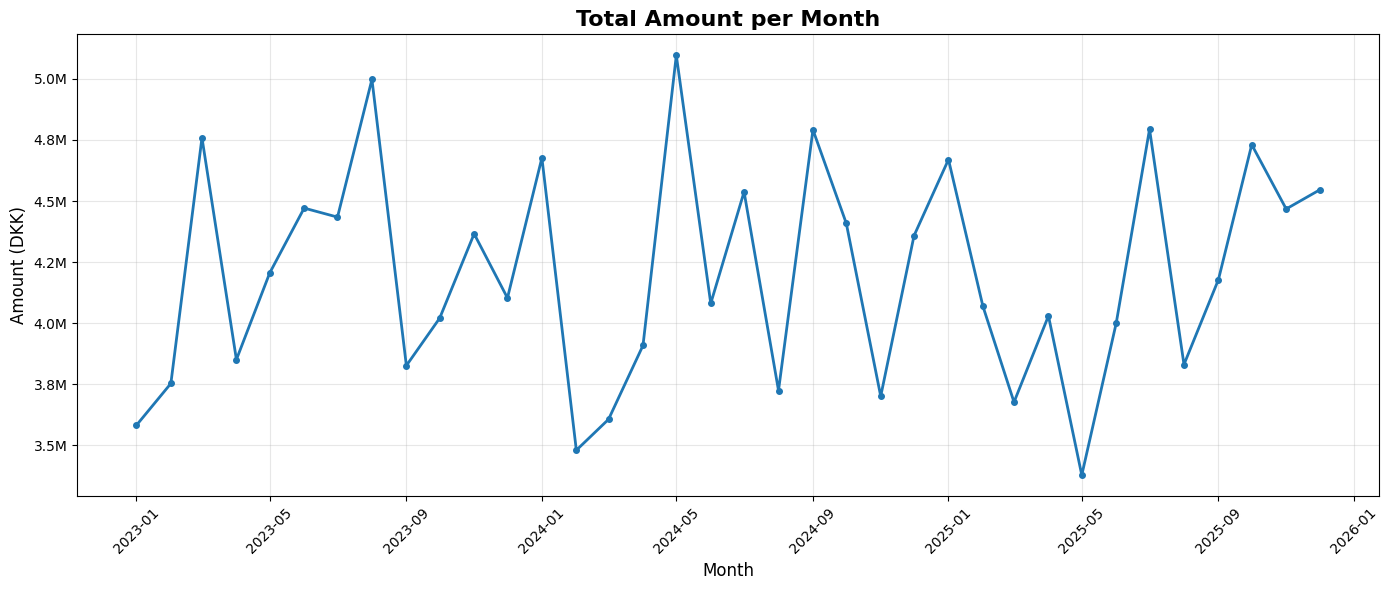

Monthly Statistics:
  Average per month: 4,197,672 DKK
  Min month: 3,378,382 DKK
  Max month: 5,096,515 DKK
  Std deviation: 454,016 DKK


In [55]:
import matplotlib.pyplot as plt

# Aggregate amount by year-month
monthly_data = erp_full.groupby(erp_full['date'].dt.to_period('M'))['amount'].sum().reset_index()
monthly_data['date'] = monthly_data['date'].dt.to_timestamp()

# Create plot
plt.figure(figsize=(14, 6))
plt.plot(monthly_data['date'], monthly_data['amount'], marker='o', linewidth=2, markersize=4)
plt.title('Total Amount per Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Amount (DKK)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Format y-axis to show values in millions
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.show()

# Show summary statistics
print(f"Monthly Statistics:")
print(f"  Average per month: {monthly_data['amount'].mean():,.0f} DKK")
print(f"  Min month: {monthly_data['amount'].min():,.0f} DKK")
print(f"  Max month: {monthly_data['amount'].max():,.0f} DKK")
print(f"  Std deviation: {monthly_data['amount'].std():,.0f} DKK")

## Enhanced ERP Generation with Growth & Seasonality

**New Features:**
1. **Year-over-Year Growth**: Apply different growth rates per year (e.g., 5% growth in 2024, 8% in 2025)
2. **Intra-Year Seasonality**: Control monthly patterns (e.g., weak Q1, strong Q4)

In [67]:
def create_erp_data_with_growth(
    df: pd.DataFrame,
    year = 2025,
    noise_pct: float = 0.05,
    max_lines_per_doc: int = 25,
    target_qty_per_line: float = 20.0,
    qty_sigma: float = 0.6,
    year_growth_rates: dict = None,  # e.g., {2023: 1.0, 2024: 1.05, 2025: 1.10}
    monthly_weights: list = None,     # e.g., [0.7, 0.7, 0.8, ...] 12 values for each month
    rng = None
) -> pd.DataFrame:
    """
    Create ERP data with year-over-year growth and intra-year seasonality.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input data with columns: bu_id, party_id, account_id, unit_price, 
        markdown, category, annual_spend, item_id
    year : int or tuple
        Single year or (year_start, year_end)
    noise_pct : float
        Random noise variation
    max_lines_per_doc : int
        Maximum lines per document
    target_qty_per_line : float
        Target quantity per line
    qty_sigma : float
        Quantity variability
    year_growth_rates : dict, optional
        Growth multipliers per year. Example:
        {2023: 1.0, 2024: 1.05, 2025: 1.10}  # 5% growth 2024, 10% total by 2025
        If None, all years get equal amounts (no growth)
    monthly_weights : list, optional
        12 values (one per month) to control intra-year distribution.
        Example: [0.7, 0.7, 0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3]
        (weak Jan-Feb, strong Nov-Dec)
        Values are relative - they'll be normalized to sum correctly.
        If None, uniform distribution across months.
    rng : np.random.Generator, optional
        Random number generator
        
    Returns
    -------
    pd.DataFrame
        ERP transaction data with growth and seasonality
        
    Examples
    --------
    # Year-over-year growth: 2023 baseline, 2024 +5%, 2025 +10%
    erp = create_erp_data_with_growth(
        df_revenue, 
        year=(2023, 2025),
        year_growth_rates={2023: 1.0, 2024: 1.05, 2025: 1.10}
    )
    
    # Seasonality: weak Q1, strong Q4
    erp = create_erp_data_with_growth(
        df_revenue,
        year=2025,
        monthly_weights=[0.7, 0.7, 0.8, 0.9, 0.95, 1.0, 1.0, 1.05, 1.1, 1.2, 1.3, 1.4]
    )
    
    # Both growth and seasonality
    erp = create_erp_data_with_growth(
        df_revenue,
        year=(2023, 2025),
        year_growth_rates={2023: 1.0, 2024: 1.08, 2025: 1.15},
        monthly_weights=[0.8, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3]
    )
    """
    if rng is None:
        rng = np.random.default_rng(42)
    
    # Handle year parameter
    if isinstance(year, tuple):
        year_start, year_end = year
        years = list(range(year_start, year_end + 1))
    else:
        years = [year]
    
    # Default growth rates (equal distribution)
    if year_growth_rates is None:
        year_growth_rates = {y: 1.0 for y in years}
    
    # Ensure all years have growth rates
    for y in years:
        if y not in year_growth_rates:
            year_growth_rates[y] = 1.0
    
    # Calculate total growth sum for normalization
    total_growth_sum = sum(year_growth_rates[y] for y in years)
    
    # Default monthly weights (uniform)
    if monthly_weights is None:
        monthly_weights = [1.0] * 12
    
    # Normalize monthly weights to sum to 12 (so average is 1.0)
    monthly_sum = sum(monthly_weights)
    monthly_weights = [w * 12 / monthly_sum for w in monthly_weights]
    
    # Generate business days for all years
    start_date = pd.Timestamp(f"{years[0]}-01-01")
    end_date = pd.Timestamp(f"{years[-1]}-12-31")
    business_days = pd.bdate_range(start_date, end_date)
    
    rows = []
    doc_counter = 1000
    
    for idx, row in df.iterrows():
        total_annual_amount = row["annual_spend"]
        unit_price = max(row["unit_price"], 1.0)
        category = row["category"]
        
        # Process each year
        for year_val in years:
            # Apply year-specific growth
            year_multiplier = year_growth_rates[year_val]
            year_amount = (total_annual_amount * year_multiplier) / total_growth_sum
            
            # Get business days for this year
            year_business_days = business_days[business_days.year == year_val]
            
            # Group business days by month
            year_df = pd.DataFrame({'date': year_business_days})
            year_df['month'] = year_df['date'].dt.month
            months_available = year_df.groupby('month')['date'].apply(list).to_dict()
            
            # Distribute amount across months using weights
            monthly_amounts = {}
            for month in range(1, 13):
                if month in months_available:
                    monthly_amounts[month] = (year_amount / 12) * monthly_weights[month - 1]
            
            # Process each month
            for month, month_amount in monthly_amounts.items():
                if month_amount <= 0:
                    continue
                
                # Calculate docs for this month's amount
                target_doc_value = unit_price * min(max_lines_per_doc, 10)
                target_doc_value = max(target_doc_value, 5000)
                
                n_docs = max(1, int(np.ceil(month_amount / target_doc_value)))
                
                # Split month amount across documents
                month_cents = int(month_amount * 100)
                if n_docs == 1:
                    doc_amounts = [month_amount]
                else:
                    doc_cents = rng.multinomial(month_cents, np.ones(n_docs) / n_docs)
                    doc_amounts = doc_cents / 100.0
                
                # Get this month's business days
                month_days = months_available[month]
                
                # Create documents
                for doc_idx, doc_amount in enumerate(doc_amounts):
                    if doc_amount <= 0:
                        continue
                    
                    # Calculate lines
                    z = rng.lognormal(mean=0.0, sigma=qty_sigma)
                    tq = max(1.0, target_qty_per_line * z)
                    
                    expected_lines = doc_amount / (unit_price * tq)
                    expected_lines = max(1.0, min(expected_lines, max_lines_per_doc * 2))
                    
                    if expected_lines < 700:
                        n_lines = max(1, min(max_lines_per_doc, int(rng.poisson(expected_lines))))
                    else:
                        n_lines = max(1, min(max_lines_per_doc, int(rng.normal(expected_lines, np.sqrt(expected_lines)))))
                    
                    # Split document across lines
                    doc_cents = int(doc_amount * 100)
                    if n_lines == 1:
                        line_amounts = [doc_amount]
                    else:
                        line_cents = rng.multinomial(doc_cents, np.ones(n_lines) / n_lines)
                        line_amounts = line_cents / 100.0
                    
                    # Random date from this month
                    doc_date = pd.Timestamp(rng.choice(month_days))
                    
                    # Document number
                    doc_number = f"DOC-{doc_counter:06d}"
                    doc_counter += 1
                    
                    # Category-specific settings
                    if category == "Revenue":
                        debit_credit = "Credit"
                        sign = 1.0
                        customer_name = row["party_id"]
                        vendor_name = None
                    else:  # COGS
                        debit_credit = "Debit"
                        sign = -1.0
                        customer_name = None
                        vendor_name = row["party_id"]
                    
                    # Create lines
                    for line_amount in line_amounts:
                        if line_amount <= 0:
                            continue
                        
                        qnoise = rng.lognormal(mean=0.0, sigma=0.5)
                        quantity = np.ceil(max(1.0, (line_amount / unit_price) * qnoise))
                    
                        signed_amount = sign * quantity*unit_price
                        
                        transaction = {
                            "document_number": doc_number,
                            "date": doc_date,
                            "bu_id": row["bu_id"],
                            "party_id": row["party_id"],
                            "account_id": row["account_id"],
                            "item_id": row["item_id"],
                            "debit_credit": debit_credit,
                            "amount": signed_amount,
                            "quantity": quantity,
                            "customer_name": customer_name,
                            "vendor_name": vendor_name,
                            "category": category
                        }
                        
                        rows.append(transaction)
    
    # Create DataFrame and sort
    erp_df = pd.DataFrame(rows)
    erp_df = erp_df.sort_values("date").reset_index(drop=True)
    
    return erp_df

### Example 1: Year-over-Year Growth

Generate data for 2023-2025 with realistic growth:
- 2023: Baseline
- 2024: +5% growth
- 2025: +10% total growth from baseline

In [117]:
# Example 1: Year-over-year growth
erp_growth = create_erp_data_with_growth(
    df_revenue,
    year=(2023, 2025),
    year_growth_rates={
        2023: 1.0,   
        2024: 1.05,   # 5% growth
        2025: 1.10    # 10% total growth
    },
    max_lines_per_doc=25
)

print("Year-over-Year Growth Example:")
yearly_totals = erp_growth.groupby(erp_growth['date'].dt.year)['amount'].sum()
for year, amount in yearly_totals.items():
    print(f"  {year}: {amount:,.0f} DKK")

# Calculate growth rates
print("\nGrowth rates:")
for i, year in enumerate(yearly_totals.index[1:], 1):
    prev_year = yearly_totals.index[i-1]
    growth = (yearly_totals[year] / yearly_totals[prev_year] - 1) * 100
    print(f"  {prev_year} → {year}: {growth:+.1f}%")

Year-over-Year Growth Example:
  2023: 101,651,449 DKK
  2024: 107,177,917 DKK
  2025: 111,997,939 DKK

Growth rates:
  2023 → 2024: +5.4%
  2024 → 2025: +4.5%


### Example 2: Intra-Year Seasonality

Generate data for 2025 with weak first 6 months and strong last 6 months:
- Jan-Jun: Below average (0.7-0.9x)
- Jul-Dec: Above average (1.1-1.3x)

In [69]:
# Example 2: Intra-year seasonality (weak H1, strong H2)
erp_seasonal = create_erp_data_with_growth(
    df_revenue,
    year=2025,
    monthly_weights=[
        0.7, 0.75, 0.8,   # Jan-Mar: Weak
        0.85, 0.9, 0.95,  # Apr-Jun: Below avg
        1.05, 1.1, 1.15,  # Jul-Sep: Above avg
        1.2, 1.25, 1.3    # Oct-Dec: Strong
    ],
    max_lines_per_doc=25
)

print("Intra-Year Seasonality Example (2025):")
monthly_totals = erp_seasonal.groupby(erp_seasonal['date'].dt.month)['amount'].sum()
for month, amount in monthly_totals.items():
    month_name = pd.Timestamp(f"2025-{month:02d}-01").strftime('%b')
    print(f"  {month_name}: {amount:,.0f} DKK")

# Compare H1 vs H2
h1 = monthly_totals[1:7].sum()
h2 = monthly_totals[7:13].sum()
print(f"\nHalf-year comparison:")
print(f"  H1 (Jan-Jun): {h1:,.0f} DKK ({h1/(h1+h2)*100:.1f}%)")
print(f"  H2 (Jul-Dec): {h2:,.0f} DKK ({h2/(h1+h2)*100:.1f}%)")

Intra-Year Seasonality Example (2025):
  Jan: 18,453,642 DKK
  Feb: 19,402,468 DKK
  Mar: 20,451,682 DKK
  Apr: 21,769,353 DKK
  May: 23,886,509 DKK
  Jun: 25,246,882 DKK
  Jul: 27,166,116 DKK
  Aug: 29,108,622 DKK
  Sep: 30,276,935 DKK
  Oct: 31,541,202 DKK
  Nov: 32,188,365 DKK
  Dec: 34,049,910 DKK

Half-year comparison:
  H1 (Jan-Jun): 137,923,010 DKK (46.7%)
  H2 (Jul-Dec): 157,165,034 DKK (53.3%)


### Example 3: Combined - Growth + Seasonality

Realistic scenario: Multi-year growth WITH seasonal patterns each year

In [118]:
# Example 3: Both growth AND seasonality
erp_combined = create_erp_data_with_growth(
    df_revenue,
    year=(2023, 2025),
    year_growth_rates={
        2023: 0.92,    # 8% down 
        2024: 1.0,     # Baseline
        2025: 1.2     # 15% total growth
    },
    monthly_weights=[
        0.75, 0.8, 0.85,   # Q1: Weak
        0.9, 0.95, 1.0,    # Q2: Below average
        1.15, 1.1, 1.15,   # Q3: Above average  
        1.2, 1.25, 1.3     # Q4: Strong
    ],
    max_lines_per_doc=25
)

print("Combined Growth + Seasonality (2023-2025):")
print("\n" + "="*60)

# Yearly totals with growth
yearly = erp_combined.groupby(erp_combined['date'].dt.year)['amount'].sum()
print("\nYear-over-Year Growth:")
for year, amount in yearly.items():
    print(f"  {year}: {amount:,.0f} DKK")

# Growth rates
print("\nGrowth Rates:")
for i in range(1, len(yearly)):
    growth = (yearly.iloc[i] / yearly.iloc[i-1] - 1) * 100
    print(f"  {yearly.index[i-1]} → {yearly.index[i]}: {growth:+.1f}%")

# Seasonal pattern for each year
print("\n" + "="*60)
print("\nSeasonal Pattern (Q1 vs Q4):")
for year in yearly.index:
    year_data = erp_combined[erp_combined['date'].dt.year == year]
    q1 = year_data[year_data['date'].dt.quarter == 1]['amount'].sum()
    q4 = year_data[year_data['date'].dt.quarter == 4]['amount'].sum()
    print(f"  {year}: Q1={q1:,.0f}, Q4={q4:,.0f}, Q4/Q1={q4/q1:.2f}x")

Combined Growth + Seasonality (2023-2025):


Year-over-Year Growth:
  2023: 94,196,387 DKK
  2024: 103,406,126 DKK
  2025: 122,807,851 DKK

Growth Rates:
  2023 → 2024: +9.8%
  2024 → 2025: +18.8%


Seasonal Pattern (Q1 vs Q4):
  2023: Q1=18,313,571, Q4=27,997,438, Q4/Q1=1.53x
  2024: Q1=20,180,462, Q4=31,156,762, Q4/Q1=1.54x
  2025: Q1=23,616,127, Q4=36,979,315, Q4/Q1=1.57x


In [137]:
df_products.sort_values("unit_price", ascending=True).head(50)

,item_name,unit_price,item_id
140,Store opening discounts,0.0,1119
139,In-app coupon reductions,0.0,1118
129,Bulk purchase discounts,0.0,1108
130,Online special offers,0.0,1109
127,Retail promotional discounts,0.0,1106
128,Clearance sale reductions,0.0,1107
132,Holiday campaign reductions,0.0,1111
131,Customer loyalty discounts,0.0,1110
136,VIP customer reductions,0.0,1115
135,Online flash sale discounts,0.0,1114


In [132]:
erp_combined["item_id"].value_counts()

item_id
1173    13270
1174     4013
1108     3350
1131     3350
1106     2875
        ...  
1153       48
1148       47
1074       46
1015       46
1034       43
Name: count, Length: 178, dtype: int64

In [122]:
erp_combined.sort_values("quantity", ascending=False).head(5)

,document_number,date,bu_id,party_id,account_id,item_id,debit_credit,amount,quantity,customer_name,vendor_name,category
128800,DOC-028599,2025-11-18,BU014,CUS048,4002,1114,Credit,1968.0,1968.0,CUS048,None,Revenue
34998,DOC-033472,2023-11-17,BU004,CUS011,4005,1131,Credit,1352.0,1352.0,CUS011,None,Revenue
120416,DOC-027919,2025-09-25,BU005,CUS024,4002,1107,Credit,1346.0,1346.0,CUS024,None,Revenue
780,DOC-028068,2023-01-10,BU008,CUS004,4002,1109,Credit,1293.0,1293.0,CUS004,None,Revenue
120397,DOC-027919,2025-09-25,BU005,CUS024,4002,1107,Credit,1236.0,1236.0,CUS024,None,Revenue


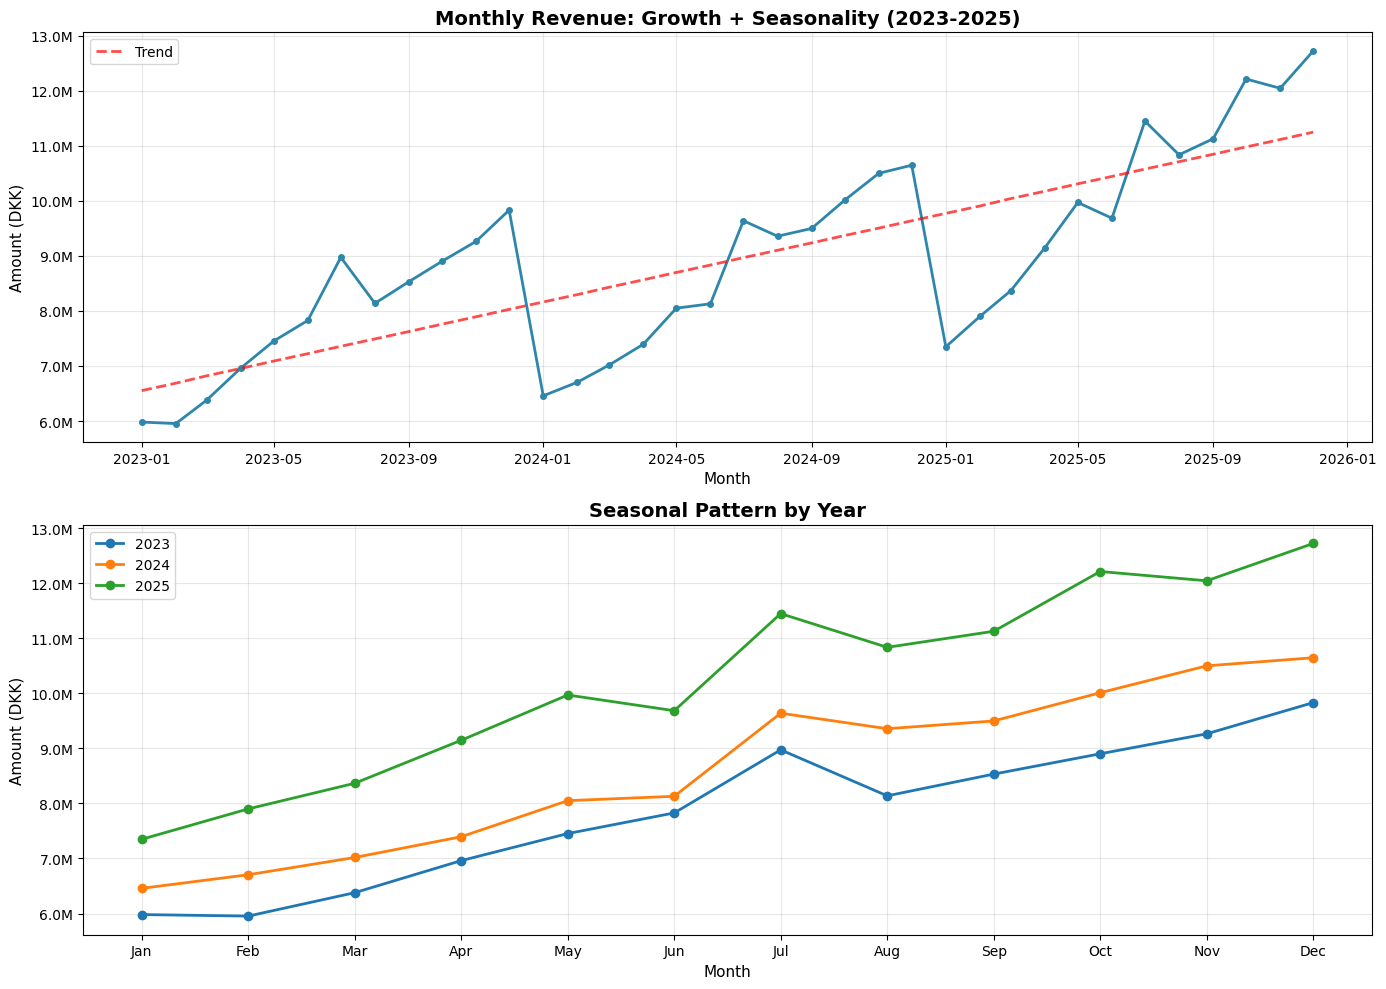

In [79]:
# Visualize Growth + Seasonality
import matplotlib.pyplot as plt  

monthly_data = erp_combined.groupby(erp_combined['date'].dt.to_period('M'))['amount'].sum().reset_index()
monthly_data['date'] = monthly_data['date'].dt.to_timestamp()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full timeline showing growth + seasonality
ax1.plot(monthly_data['date'], monthly_data['amount'], marker='o', linewidth=2, markersize=4, color='#2E86AB')
ax1.set_title('Monthly Revenue: Growth + Seasonality (2023-2025)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=11)
ax1.set_ylabel('Amount (DKK)', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Add trend line
from scipy import stats
x_numeric = np.arange(len(monthly_data))
slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, monthly_data['amount'])
trend_line = slope * x_numeric + intercept
ax1.plot(monthly_data['date'], trend_line, '--', color='red', linewidth=2, label='Trend', alpha=0.7)
ax1.legend()

# Plot 2: Seasonal pattern comparison across years
erp_combined['year'] = erp_combined['date'].dt.year
erp_combined['month'] = erp_combined['date'].dt.month

for year in erp_combined['year'].unique():
    year_data = erp_combined[erp_combined['year'] == year].groupby('month')['amount'].sum()
    ax2.plot(year_data.index, year_data.values, marker='o', linewidth=2, label=f'{year}')

ax2.set_title('Seasonal Pattern by Year', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=11)
ax2.set_ylabel('Amount (DKK)', fontsize=11)
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

In [ ]:
erp_combined["Year"]

,document_number,date,bu_id,party_id,account_id,item_id,debit_credit,amount,quantity,customer_name,vendor_name,category,year,month
0,DOC-006515,2023-01-02,BU005,CUS011,4001,1020,Credit,2443.0,7.0,CUS011,None,Revenue,2023,1
1,DOC-027835,2023-01-02,BU005,CUS024,4002,1107,Credit,274.0,274.0,CUS024,None,Revenue,2023,1
2,DOC-027835,2023-01-02,BU005,CUS024,4002,1107,Credit,311.0,311.0,CUS024,None,Revenue,2023,1
3,DOC-027835,2023-01-02,BU005,CUS024,4002,1107,Credit,100.0,100.0,CUS024,None,Revenue,2023,1
4,DOC-027835,2023-01-02,BU005,CUS024,4002,1107,Credit,110.0,110.0,CUS024,None,Revenue,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136192,DOC-038384,2025-12-31,BU008,BU003,4007,1177,Credit,329.0,47.0,BU003,None,Revenue,2025,12
136193,DOC-038384,2025-12-31,BU008,BU003,4007,1177,Credit,392.0,56.0,BU003,None,Revenue,2025,12
136194,DOC-038384,2025-12-31,BU008,BU003,4007,1177,Credit,245.0,35.0,BU003,None,Revenue,2025,12
136195,DOC-038384,2025-12-31,BU008,BU003,4007,1177,Credit,385.0,55.0,BU003,None,Revenue,2025,12


## Budget Data Generation

Create budget data from actual ERP data for comparison purposes.

In [85]:
def create_budget_from_erp(
    df_erp: pd.DataFrame,
    budget_years: list = None,      # e.g., [2024, 2025] - will use previous year as baseline
    price_growth: float = 0.02,     # 2% price increase
    volume_growth: float = 0.01,    # 1% volume increase  
    noise_pct: float = 0.08,        # 8% random noise
    optimism_bias: float = 0.05,    # Budget typically 5% more optimistic
    rounding: int = 100,            # Round to nearest 100
    budget_day: int = 1,            # Budget date (1st of month)
    doc_prefix: str = "BUDG-",
    seed: int = 42
) -> pd.DataFrame:
    """
    Generate budget data from actual ERP data.
    
    Budget uses previous year as baseline and applies:
    - Price growth (e.g., 2% inflation)
    - Volume growth (e.g., 1% more units)
    - Random noise to simulate estimation uncertainty
    - Optional optimism bias (budgets tend to be optimistic)
    
    Parameters
    ----------
    df_erp : pd.DataFrame
        Actual ERP data with columns: date, amount, quantity, account_id, 
        bu_id, party_id, item_id, category, etc.
    budget_years : list, optional
        Years to generate budget for. Uses previous year as baseline.
        E.g., [2024, 2025] uses 2023 for 2024 budget, 2024 for 2025 budget.
        If None, generates for all years after the first.
    price_growth : float
        Expected price increase (e.g., 0.02 = 2%)
    volume_growth : float
        Expected volume increase (e.g., 0.01 = 1%)
    noise_pct : float
        Random noise as percentage (e.g., 0.08 = ±8%)
    optimism_bias : float
        Systematic optimism in budget (e.g., 0.05 = 5% higher)
    rounding : int
        Round amounts to nearest N (e.g., 100)
    budget_day : int
        Day of month for budget dates (typically 1)
    doc_prefix : str
        Prefix for budget document numbers
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    pd.DataFrame
        Budget data with same structure as ERP data plus 'scenario' column
        
    Examples
    --------
    # Generate budget for 2024 and 2025 using actuals from prior years
    budget = create_budget_from_erp(
        erp_combined,
        budget_years=[2024, 2025],
        price_growth=0.03,      # 3% price increase expected
        volume_growth=0.02,     # 2% volume growth expected
        optimism_bias=0.05      # Budget 5% more optimistic than reality
    )
    """
    rng = np.random.default_rng(seed)
    
    df = df_erp.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    years = sorted(df['year'].unique())
    
    # If no budget years specified, use all years after first
    if budget_years is None:
        budget_years = years[1:]
    
    # Group keys for aggregation
    group_keys = ['year', 'month', 'account_id', 'bu_id', 'party_id', 'item_id', 'category']
    available_keys = [k for k in group_keys if k in df.columns]
    
    budget_frames = []
    
    for budget_year in budget_years:
        baseline_year = budget_year - 1
        
        # Get baseline data from previous year
        baseline = df[df['year'] == baseline_year].copy()
        
        if baseline.empty:
            print(f"Warning: No data for baseline year {baseline_year}, skipping budget {budget_year}")
            continue
        
        # Aggregate to monthly level per dimension
        agg = baseline.groupby(available_keys).agg({
            'amount': 'sum',
            'quantity': 'sum',
            'document_number': 'first',  # Keep one doc number for reference
            'debit_credit': 'first',
            'customer_name': 'first',
            'vendor_name': 'first'
        }).reset_index()
        
        # Calculate unit price from baseline
        agg['unit_price'] = np.where(
            agg['quantity'].abs() > 0,
            agg['amount'] / agg['quantity'],
            0
        )
        
        # Store original sign
        agg['sign'] = np.sign(agg['amount']).replace(0, 1)
        
        # Apply growth and noise
        # Price growth
        new_unit_price = agg['unit_price'] * (1 + price_growth)
        
        # Volume growth with noise
        volume_noise = rng.normal(1 + volume_growth, noise_pct, size=len(agg))
        volume_noise = np.maximum(volume_noise, 0.5)  # Don't go below 50%
        new_quantity = agg['quantity'] * volume_noise
        
        # Calculate new amount
        # For items with valid unit price, use price × quantity
        # Otherwise, apply combined growth to amount
        has_valid_price = (agg['unit_price'] != 0) & np.isfinite(agg['unit_price'])
        
        new_amount = np.where(
            has_valid_price,
            new_unit_price * new_quantity,
            agg['amount'].abs() * (1 + price_growth) * volume_noise
        )
        
        # Apply optimism bias (budget tends to be optimistic)
        new_amount = new_amount * (1 + optimism_bias)
        
        # Restore original sign (Revenue positive, COGS negative)
        new_amount = new_amount * agg['sign']
        
        # Round amounts
        if rounding and rounding > 1:
            new_amount = (new_amount / rounding).round() * rounding
        
        # Update debit/credit based on new amount
        new_debit_credit = np.where(new_amount >= 0, 'Debit', 'Credit')
        
        # Create budget dates (first day of each month)
        budget_dates = pd.to_datetime({
            'year': budget_year,
            'month': agg['month'],
            'day': budget_day
        })
        
        # Build budget dataframe
        budget_df = agg[available_keys].copy()
        budget_df['date'] = budget_dates
        budget_df['amount'] = new_amount
        budget_df['quantity'] = np.round(np.abs(new_quantity), 2)
        budget_df['debit_credit'] = new_debit_credit
        budget_df['document_number'] = doc_prefix + agg['document_number'].astype(str)
        budget_df['scenario'] = 'Budget'
        
        # Copy customer/vendor names
        if 'customer_name' in agg.columns:
            budget_df['customer_name'] = agg['customer_name']
        if 'vendor_name' in agg.columns:
            budget_df['vendor_name'] = agg['vendor_name']
        
        budget_frames.append(budget_df)
    
    if not budget_frames:
        return pd.DataFrame()
    
    # Combine all budget years
    budget_all = pd.concat(budget_frames, ignore_index=True)
    
    # Sort by date
    budget_all = budget_all.sort_values(['date', 'document_number']).reset_index(drop=True)
    
    return budget_all

### Generate Budget Data

Create budget for comparison with actuals

In [96]:
# Generate budget for 2024 and 2025 using the combined actuals
budget_data = create_budget_from_erp(
    erp_combined,
    budget_years=[2024, 2025],
    price_growth=0.03,       # 8% price increase expected
    volume_growth=0.05,       # 10% volume growth expected
    optimism_bias=0.01,      # Budget 5% more optimistic
    noise_pct=0.08           # 8% estimation uncertainty
)

print(f"✓ Generated {len(budget_data):,} budget lines")
print(f"✓ Budget years: {sorted(budget_data['date'].dt.year.unique())}")
print(f"\nBudget Summary by Year:")
budget_by_year = budget_data.groupby(budget_data['date'].dt.year).agg({
    'amount': 'sum',
    'document_number': 'nunique'
})
budget_by_year.columns = ['Total Amount', '# Unique Docs']
print(budget_by_year)

print(f"\nBudget by Category:")
budget_by_cat = budget_data.groupby(['category']).agg({
    'amount': 'sum'
})
print(budget_by_cat)

✓ Generated 5,328 budget lines
✓ Budget years: [np.int32(2024), np.int32(2025)]

Budget Summary by Year:
      Total Amount  # Unique Docs
date                             
2024   102744700.0           2664
2025   113040200.0           2664

Budget by Category:
               amount
category             
Revenue   215784900.0


### Compare Budget vs Actuals

In [97]:
# Combine actuals and budget for comparison
actuals = erp_combined.copy()
actuals['scenario'] = 'Actual'

# Combine both
comparison = pd.concat([actuals, budget_data], ignore_index=True)

# Compare by year and category
print("Budget vs Actual Comparison:")
print("="*70)

for year in sorted(comparison['date'].dt.year.unique()):
    if year < 2024:  # Only compare years with budget
        continue
    
    print(f"\n{year}:")
    year_data = comparison[comparison['date'].dt.year == year]
    
    pivot = year_data.groupby(['category', 'scenario'])['amount'].sum().unstack(fill_value=0)
    
    if 'Actual' in pivot.columns and 'Budget' in pivot.columns:
        pivot['Variance'] = pivot['Actual'] - pivot['Budget']
        pivot['Variance %'] = (pivot['Variance'] / pivot['Budget'].abs()) * 100
    
    print(pivot.to_string())

# Monthly comparison for visualization
print(f"\n{'='*70}")
print("Monthly Trend Comparison:")
monthly_comp = comparison.groupby([
    comparison['date'].dt.to_period('M'),
    'scenario'
])['amount'].sum().unstack(fill_value=0)
print(monthly_comp.tail(12))

Budget vs Actual Comparison:

2024:
scenario       Actual       Budget  Variance  Variance %
category                                                
Revenue   103406126.0  102744700.0  661426.0    0.643757

2025:
scenario       Actual       Budget   Variance  Variance %
category                                                 
Revenue   122807851.0  113040200.0  9767651.0    8.640865

Monthly Trend Comparison:
scenario      Actual      Budget
date                            
2025-01    7349007.0   7033500.0
2025-02    7900647.0   7401600.0
2025-03    8366473.0   7760100.0
2025-04    9147432.0   7900200.0
2025-05    9969742.0   8890300.0
2025-06    9684388.0   8751700.0
2025-07   11447976.0  10534800.0
2025-08   10835636.0  10188200.0
2025-09   11127235.0  10353900.0
2025-10   12212805.0  10961900.0
2025-11   12044331.0  11519800.0
2025-12   12722179.0  11744200.0


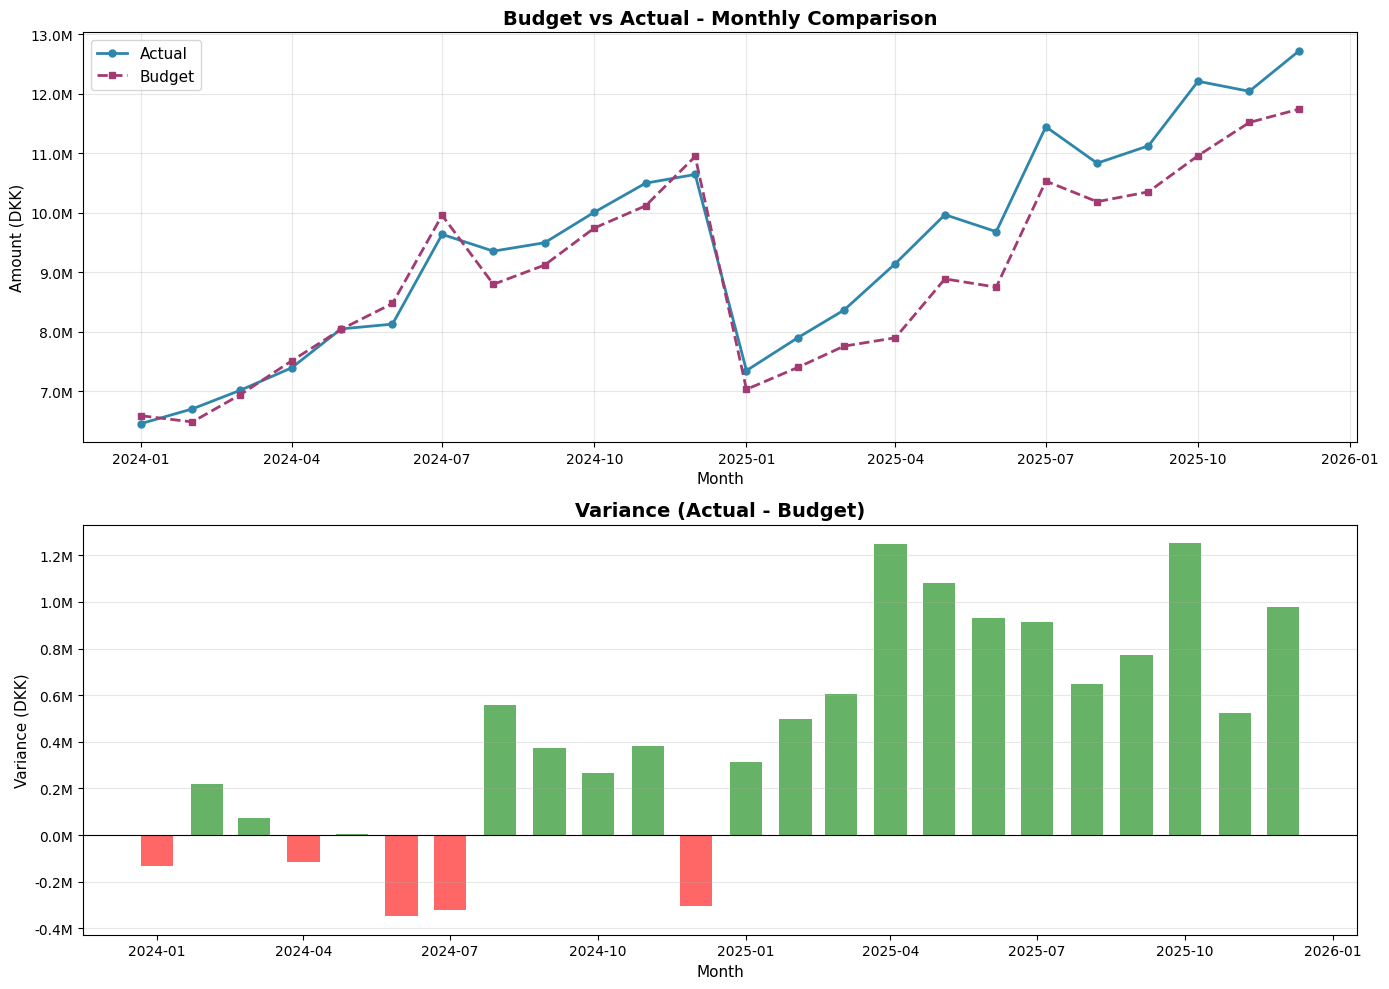


SUMMARY STATISTICS:
Total Actual:       226,213,977 DKK
Total Budget:       215,784,900 DKK
Variance:            10,429,077 DKK (+4.8%)

Average Monthly Variance: 434,545 DKK
Std Dev of Variance:      488,506 DKK


In [98]:
# Visualize Budget vs Actuals
import matplotlib.pyplot as plt

# Filter to years with budget
budget_years = sorted(budget_data['date'].dt.year.unique())
comp_data = comparison[comparison['date'].dt.year.isin(budget_years)]

# Monthly aggregation
monthly = comp_data.groupby([
    comp_data['date'].dt.to_period('M'),
    'scenario'
])['amount'].sum().unstack(fill_value=0)
monthly.index = monthly.index.to_timestamp()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Budget vs Actual over time
ax1 = axes[0]
if 'Actual' in monthly.columns:
    ax1.plot(monthly.index, monthly['Actual'], marker='o', linewidth=2, 
             label='Actual', color='#2E86AB', markersize=5)
if 'Budget' in monthly.columns:
    ax1.plot(monthly.index, monthly['Budget'], marker='s', linewidth=2, 
             label='Budget', color='#A23B72', markersize=5, linestyle='--')

ax1.set_title('Budget vs Actual - Monthly Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=11)
ax1.set_ylabel('Amount (DKK)', fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Plot 2: Variance (Actual - Budget)
ax2 = axes[1]
if 'Actual' in monthly.columns and 'Budget' in monthly.columns:
    variance = monthly['Actual'] - monthly['Budget']
    colors = ['green' if v > 0 else 'red' for v in variance]
    ax2.bar(monthly.index, variance, color=colors, alpha=0.6, width=20)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    ax2.set_title('Variance (Actual - Budget)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Month', fontsize=11)
    ax2.set_ylabel('Variance (DKK)', fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

# Summary statistics
if 'Actual' in monthly.columns and 'Budget' in monthly.columns:
    total_actual = monthly['Actual'].sum()
    total_budget = monthly['Budget'].sum()
    total_variance = total_actual - total_budget
    variance_pct = (total_variance / abs(total_budget)) * 100
    
    print(f"\n{'='*70}")
    print("SUMMARY STATISTICS:")
    print(f"{'='*70}")
    print(f"Total Actual:   {total_actual:>15,.0f} DKK")
    print(f"Total Budget:   {total_budget:>15,.0f} DKK")
    print(f"Variance:       {total_variance:>15,.0f} DKK ({variance_pct:+.1f}%)")
    print(f"\nAverage Monthly Variance: {variance.mean():,.0f} DKK")
    print(f"Std Dev of Variance:      {variance.std():,.0f} DKK")

## Using Pre-defined Schemas

Load and use predefined business scenarios

In [ ]:
# Import schemas
import sys
from pathlib import Path
sys.path.append(str(Path().resolve()))

from schemas.erp_schemas import (
    get_schema, 
    list_schemas,
    SCHEMA_REGISTRY
)

# List all available schemas
list_schemas()

### Example: Generate ERP Data Using Schemas

In [ ]:
# Example 1: Recovery & Growth scenario
recovery_schema = get_schema('recovery_growth')

erp_recovery = create_erp_data_with_growth(
    df_revenue,
    year=(2023, 2025),
    year_growth_rates=recovery_schema['year_growth_rates'],
    monthly_weights=recovery_schema['monthly_weights'],
    max_lines_per_doc=25
)

print(f"📊 {recovery_schema['name']}")
print(f"   {recovery_schema['description']}\n")

yearly = erp_recovery.groupby(erp_recovery['date'].dt.year)['amount'].sum()
for year, amount in yearly.items():
    print(f"   {year}: {amount:,.0f} DKK")

# Calculate growth rates
print("\n   Growth rates:")
for i in range(1, len(yearly)):
    growth = (yearly.iloc[i] / yearly.iloc[i-1] - 1) * 100
    print(f"   {yearly.index[i-1]} → {yearly.index[i]}: {growth:+.1f}%")

In [ ]:
# Compare all 5 schemas side-by-side
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

schema_names = list(SCHEMA_REGISTRY.keys())

for idx, schema_name in enumerate(schema_names):
    schema = get_schema(schema_name)
    
    # Generate small sample data for visualization
    sample_data = create_erp_data_with_growth(
        df_revenue.head(20),  # Use small subset for speed
        year=(2023, 2025),
        year_growth_rates=schema['year_growth_rates'],
        monthly_weights=schema['monthly_weights'],
        max_lines_per_doc=10
    )
    
    # Monthly aggregation
    monthly = sample_data.groupby(sample_data['date'].dt.to_period('M'))['amount'].sum()
    monthly.index = monthly.index.to_timestamp()
    
    # Plot
    ax = axes[idx]
    ax.plot(monthly.index, monthly.values, marker='o', linewidth=2, markersize=4)
    ax.set_title(f"{schema['name']}", fontsize=12, fontweight='bold')
    ax.set_xlabel('Month', fontsize=9)
    ax.set_ylabel('Amount', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    
    # Add growth rates as text
    growth_text = f"2023: {schema['year_growth_rates'][2023]:.0%}\n"
    growth_text += f"2024: {schema['year_growth_rates'][2024]:.0%}\n"
    growth_text += f"2025: {schema['year_growth_rates'][2025]:.0%}"
    ax.text(0.02, 0.98, growth_text, transform=ax.transAxes,
            fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hide the last subplot (we have 5 schemas, 6 subplots)
axes[5].axis('off')

plt.tight_layout()
plt.suptitle('ERP Data Schemas - Comparison of Different Business Scenarios', 
             fontsize=14, fontweight='bold', y=1.00)
plt.show()